In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import keras
import tensorflow
from keras import Sequential
from keras.layers import Dense

In [144]:
df = pd.read_csv('COVID19_open_line_list.csv')

In [145]:
df = df[pd.notnull(df['age'])]
df = df[pd.notnull(df['sex'])]
df = df[pd.notnull(df['country'])]
df = df[pd.notnull(df['lives_in_Wuhan'])]
df.drop(columns = ['city','province','latitude','longitude','geo_resolution','additional_information','source','sequence_available','outcome','notes_for_discussion','location','admin3','admin2','admin1','country_new','admin_id','data_moderator_initials'])

,ID,age,sex,country,wuhan(0)_not_wuhan(1),date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,chronic_disease_binary,chronic_disease,date_death_or_discharge
258,11545,70-79,male,Japan,1,19.02.2020,20.02.2020,21.02.2020,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN
276,1771,60-69,male,Japan,1,14.01.2020,25.01.2020,28.01.2020,"chills, cough, joint pain",no,NaN,NaN,no,NaN,NaN,NaN
277,2594,60-69,male,Australia,1,23.01.2020,NaN,29.01.2020,NaN,no,NaN,Wuhan,NaN,NaN,NaN,NaN
278,3021,60-69,male,United States,1,NaN,NaN,30.01.2020,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN
287,11547,60-69,male,Japan,1,06.02.2020,21.02.2020,21.02.2020,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1575,5108,5,female,China,1,22.01.2020,27.01.2020,02.02.2020,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN
1577,9191,4,female,China,1,NaN,NaN,08.02.2020,NaN,no,25.01.2020 -,Wuhan City,NaN,NaN,NaN,NaN
1579,2362,3,female,China,1,27.01.2020,27.01.2020,29.01.2020,NaN,no,21.01.2020,Wuhan,NaN,NaN,NaN,NaN
1580,163,2,female,China,1,22.01.2020,23.01.2020,24.01.2020,"fever, sneeze",yes,21.01.2020,Wuhan,NaN,NaN,NaN,NaN


In [146]:
test = df.iloc[:,13]
symptom_set = set()
for row in list(test):
    row = str(row)
    l = row.split(",")
    for symp in l:
        symp = symp.strip()
        if symp == "nan":
            continue
        elif symp not in symptom_set:
            if "fever" in symp or "Fever" in symp:
                symptom_set.add("fever")
            else:
                symptom_set.add(symp)
        else:
            continue
print(symptom_set)

{'pneumonitis', 'runny nose', 'muscular soreness', 'rigor', 'physical discomfort', 'vomiting', 'myalgias', 'myalgia', 'soreness', 'lesions on chest radiographs', 'lack of energy', 'pleural effusion', 'coughing', 'diarrhea', 'feeling ill', 'sneeze', 'other symptoms', 'pleuritic chest pain', 'chest tightness', 'pharyngeal discomfort', 'muscle ache', 'fatigue', 'weak', 'sore throat', 'muscle soreness', 'severe dyspnea', 'pharynx', 'headache', 'respiratory symptoms', 'expectoration', 'nasal congestion', 'sneezing', 'nausea', 'cough', 'muscular stiffness', 'chest distress', 'chest pain', 'rhinorrhoea', 'pharyngalgia', 'sore limbs', 'shortness of breath', 'sore muscle', 'dizziness', 'eye irritation', 'pneumonia', 'discomfort', 'fever', 'dyspnea', 'anhelation', 'eventually showed acute left heart failure and acute coronary syndrome', 'muscle aches', 'joint pain', 'flu-like symptoms', 'muscle pain', 'weakness', 'conjunctivitis', 'asymptomatic', 'dry cough', 'diarrhoea', 'sputum', 'chills', 'sw

In [149]:
test = df.iloc[:,5]
country_dict = dict()
count = 0
for row in list(test):
    row = str(row)
    if row in country_dict:
        continue
    else:
        country_dict[row] = count
        count+= 1
print(country_dict)

{'Japan': 0, 'Australia': 1, 'United States': 2, 'Canada': 3, 'Sweden': 4, 'Germany': 5, 'Finland': 6, 'China': 7, 'Singapore': 8, 'Thailand': 9, 'Vietnam': 10, 'South Korea': 11, 'Spain': 12, 'Cambodia': 13, 'North Macedonia': 14, 'Georgia': 15, 'France': 16, 'Philippines': 17, 'Malaysia': 18, 'Greece': 19, 'Afghanistan': 20, 'Estonia': 21, 'Nepal': 22, 'Italy': 23, 'Croatia': 24, 'Pakistan': 25, 'Romania': 26}


In [150]:
cleanedData = []
count = 0
Count = 0
for index,row in df.iterrows():
    cur = []
    Count += 1
    # Clean the age column
    if row["age"].isnumeric():
        cur.append(int(row["age"]) // 10)
    else:
        if "-" in row["age"]:
            loc = row["age"].index("-")
            cur.append(int(row["age"][:loc]) // 10)
        else:
            cur.append(int(float(row["age"]) // 10))
    # Clean the sex column
    if row["sex"] == "male":
        cur.append(1)
    else:
        cur.append(0)
    # Clean the country
    cur.append(country_dict[str(row["country"])])
    # Clean the Wuhan column, check whether they are citizens in Wuhan, 1 means not Wuhan
    cur.append(row["wuhan(0)_not_wuhan(1)"])
    # Clean the sympton date
    
    # Clean the sympton
    temp = str(row["symptoms"]).lower()
    # fever, cough, pneumonitis, fatigue
    # Fever- related
    if "fever" in temp or "headache" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Cough related
    if "cou" in temp or "throa" in temp or "dry" in temp or "pharyngeal" in temp or "expectoration" in temp or "flu" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Cold related
    if "chill" in temp or "nose" in temp or "nasal" in temp or "sneez" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # pneumonitis related
    if "pneumon" in temp or "respiratory" in temp or "breath" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Muscle or fatigue, physical issue related
    if "fatigue" in temp or "myalgias" in temp or "musc" in temp or "walk" in temp or "chest" in temp or "limbs" in temp or "joint" in temp or "physical" in temp or "energy" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Stomacha related
    if "diarrhoea" in temp or "abdominal" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Other symptom or non-symptom
    if len(temp) > 0 and temp != "nan":
        cur.append(1)
    else:
        cur.append(0)
    
    # Clean the column whether live in Wuhan or have travel relations with Wuhan
    if str(row["lives_in_Wuhan"]).lower() == "nan" or str(row["lives_in_Wuhan"]).lower() == "no" or "wuhan" not in str(row["travel_history_location"]).lower():
        cur.append(0)
    else:
        cur.append(1)
        
    # Clean the target value: date_death_or_discharge
    if str(row["date_death_or_discharge"]).lower() == "nan":
        count += 1
        cur.append(0)
    else:
        cur.append(1)
    cleanedData.append(cur)
    
#print(count,Count)
#print(cleanedData)

In [151]:
import csv
f = open("CleanedConfirmedCase.csv", "a")
fieldnames = ['AgeGroups', 'Sex','Country','Wuhan?','Fever','Cough','Cold','Pneumonitis','Fatigue','Stomacha','Other Symptoms','Relation with Wuhan','Death or Not']
writer = csv.DictWriter(f, fieldnames=fieldnames)
writer.writeheader()
writer = csv.writer(f)
writer.writerows(cleanedData)
f.close()

In [152]:
df = pd.read_csv("CleanedConfirmedCase.csv")

In [153]:
df

,AgeGroups,Sex,Country,Wuhan?,Fever,Cough,Cold,Pneumonitis,Fatigue,Stomacha,Other Symptoms,Relation with Wuhan,Death or Not
0,7,1,0,1,0,0,0,0,0,0,0,0,0
1,6,1,0,1,0,1,1,0,1,0,1,0,0
2,6,1,1,1,0,0,0,0,0,0,0,0,0
3,6,1,2,1,0,0,0,0,0,0,0,0,0
4,6,1,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0,0,7,1,0,0,0,0,0,0,0,0,0
480,0,0,7,1,0,0,0,0,0,0,0,0,0
481,0,0,7,1,0,0,0,0,0,0,0,0,0
482,0,0,7,1,1,0,1,0,0,0,1,1,0


     AgeGroups  Sex  Country  Wuhan?  Fever  Cough  Cold  Pneumonitis  \
0            7    1        0       1      0      0     0            0   
1            6    1        0       1      0      1     1            0   
2            6    1        1       1      0      0     0            0   
3            6    1        2       1      0      0     0            0   
4            6    1        0       1      0      0     0            0   
..         ...  ...      ...     ...    ...    ...   ...          ...   
479          0    0        7       1      0      0     0            0   
480          0    0        7       1      0      0     0            0   
481          0    0        7       1      0      0     0            0   
482          0    0        7       1      1      0     1            0   
483          0    0       10       1      0      1     1            0   

     Fatigue  Stomacha  Other Symptoms  Relation with Wuhan  
0          0         0               0                    0  

387/387 [==============================] - 0s 63us/step - loss: 0.1524 - accuracy: 0.9612 - val_loss: 0.2775 - val_accuracy: 0.9175
Epoch 45/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1521 - accuracy: 0.9612 - val_loss: 0.2777 - val_accuracy: 0.9175
Epoch 46/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1519 - accuracy: 0.9612 - val_loss: 0.2778 - val_accuracy: 0.9175
Epoch 47/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1517 - accuracy: 0.9612 - val_loss: 0.2776 - val_accuracy: 0.9175
Epoch 48/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1516 - accuracy: 0.9612 - val_loss: 0.2774 - val_accuracy: 0.9175
Epoch 49/2000
387/387 [==============================] - 0s 63us/step - loss: 0.1512 - accuracy: 0.9612 - val_loss: 0.2778 - val_accuracy: 0.9175
Epoch 50/2000
387/387 [==============================] - 0s 64us/step - loss: 0.1513 - accuracy: 0.9612 - val_loss: 0.2776 - val_accuracy:

387/387 [==============================] - 0s 61us/step - loss: 0.1437 - accuracy: 0.9612 - val_loss: 0.2766 - val_accuracy: 0.9175
Epoch 101/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1432 - accuracy: 0.9612 - val_loss: 0.2762 - val_accuracy: 0.9175
Epoch 102/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1431 - accuracy: 0.9612 - val_loss: 0.2766 - val_accuracy: 0.9175
Epoch 103/2000
387/387 [==============================] - 0s 58us/step - loss: 0.1431 - accuracy: 0.9612 - val_loss: 0.2767 - val_accuracy: 0.9175
Epoch 104/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1429 - accuracy: 0.9612 - val_loss: 0.2762 - val_accuracy: 0.9175
Epoch 105/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1429 - accuracy: 0.9612 - val_loss: 0.2760 - val_accuracy: 0.9175
Epoch 106/2000
387/387 [==============================] - 0s 64us/step - loss: 0.1427 - accuracy: 0.9612 - val_loss: 0.2763 - val_acc

Epoch 156/2000
387/387 [==============================] - 0s 58us/step - loss: 0.1379 - accuracy: 0.9612 - val_loss: 0.2771 - val_accuracy: 0.9175
Epoch 157/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1383 - accuracy: 0.9612 - val_loss: 0.2773 - val_accuracy: 0.9175
Epoch 158/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1377 - accuracy: 0.9612 - val_loss: 0.2772 - val_accuracy: 0.9175
Epoch 159/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1376 - accuracy: 0.9612 - val_loss: 0.2763 - val_accuracy: 0.9175
Epoch 160/2000
387/387 [==============================] - 0s 65us/step - loss: 0.1381 - accuracy: 0.9612 - val_loss: 0.2769 - val_accuracy: 0.9175
Epoch 161/2000
387/387 [==============================] - 0s 58us/step - loss: 0.1374 - accuracy: 0.9612 - val_loss: 0.2766 - val_accuracy: 0.9175
Epoch 162/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1372 - accuracy: 0.9612 - val_loss: 0

Epoch 212/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1333 - accuracy: 0.9612 - val_loss: 0.2775 - val_accuracy: 0.9175
Epoch 213/2000
387/387 [==============================] - 0s 62us/step - loss: 0.1331 - accuracy: 0.9612 - val_loss: 0.2777 - val_accuracy: 0.9175
Epoch 214/2000
387/387 [==============================] - 0s 62us/step - loss: 0.1330 - accuracy: 0.9612 - val_loss: 0.2775 - val_accuracy: 0.9175
Epoch 215/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1329 - accuracy: 0.9612 - val_loss: 0.2771 - val_accuracy: 0.9175
Epoch 216/2000
387/387 [==============================] - 0s 58us/step - loss: 0.1327 - accuracy: 0.9612 - val_loss: 0.2768 - val_accuracy: 0.9175
Epoch 217/2000
387/387 [==============================] - 0s 62us/step - loss: 0.1326 - accuracy: 0.9612 - val_loss: 0.2768 - val_accuracy: 0.9175
Epoch 218/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1325 - accuracy: 0.9612 - val_loss: 0

Epoch 268/2000
387/387 [==============================] - 0s 57us/step - loss: 0.1288 - accuracy: 0.9638 - val_loss: 0.2766 - val_accuracy: 0.9175
Epoch 269/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1285 - accuracy: 0.9638 - val_loss: 0.2760 - val_accuracy: 0.9175
Epoch 270/2000
387/387 [==============================] - 0s 58us/step - loss: 0.1282 - accuracy: 0.9664 - val_loss: 0.2760 - val_accuracy: 0.9175
Epoch 271/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1283 - accuracy: 0.9664 - val_loss: 0.2774 - val_accuracy: 0.9175
Epoch 272/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1285 - accuracy: 0.9638 - val_loss: 0.2765 - val_accuracy: 0.9175
Epoch 273/2000
387/387 [==============================] - 0s 58us/step - loss: 0.1283 - accuracy: 0.9664 - val_loss: 0.2769 - val_accuracy: 0.9175
Epoch 274/2000
387/387 [==============================] - 0s 57us/step - loss: 0.1281 - accuracy: 0.9638 - val_loss: 0

Epoch 324/2000
387/387 [==============================] - 0s 62us/step - loss: 0.1249 - accuracy: 0.9664 - val_loss: 0.2776 - val_accuracy: 0.9278
Epoch 325/2000
387/387 [==============================] - 0s 66us/step - loss: 0.1246 - accuracy: 0.9664 - val_loss: 0.2763 - val_accuracy: 0.9278
Epoch 326/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1249 - accuracy: 0.9664 - val_loss: 0.2777 - val_accuracy: 0.9278
Epoch 327/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1247 - accuracy: 0.9664 - val_loss: 0.2776 - val_accuracy: 0.9278
Epoch 328/2000
387/387 [==============================] - 0s 58us/step - loss: 0.1245 - accuracy: 0.9664 - val_loss: 0.2783 - val_accuracy: 0.9278
Epoch 329/2000
387/387 [==============================] - 0s 57us/step - loss: 0.1248 - accuracy: 0.9664 - val_loss: 0.2797 - val_accuracy: 0.9278
Epoch 330/2000
387/387 [==============================] - 0s 57us/step - loss: 0.1243 - accuracy: 0.9664 - val_loss: 0

Epoch 380/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1212 - accuracy: 0.9664 - val_loss: 0.2802 - val_accuracy: 0.9278
Epoch 381/2000
387/387 [==============================] - 0s 58us/step - loss: 0.1214 - accuracy: 0.9664 - val_loss: 0.2795 - val_accuracy: 0.9278
Epoch 382/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1215 - accuracy: 0.9664 - val_loss: 0.2801 - val_accuracy: 0.9278
Epoch 383/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1215 - accuracy: 0.9664 - val_loss: 0.2803 - val_accuracy: 0.9278
Epoch 384/2000
387/387 [==============================] - 0s 57us/step - loss: 0.1212 - accuracy: 0.9664 - val_loss: 0.2823 - val_accuracy: 0.9278
Epoch 385/2000
387/387 [==============================] - 0s 56us/step - loss: 0.1214 - accuracy: 0.9664 - val_loss: 0.2793 - val_accuracy: 0.9278
Epoch 386/2000
387/387 [==============================] - 0s 56us/step - loss: 0.1209 - accuracy: 0.9664 - val_loss: 0

Epoch 436/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1181 - accuracy: 0.9664 - val_loss: 0.2799 - val_accuracy: 0.9278
Epoch 437/2000
387/387 [==============================] - 0s 58us/step - loss: 0.1184 - accuracy: 0.9664 - val_loss: 0.2803 - val_accuracy: 0.9278
Epoch 438/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1184 - accuracy: 0.9664 - val_loss: 0.2807 - val_accuracy: 0.9278
Epoch 439/2000
387/387 [==============================] - 0s 57us/step - loss: 0.1183 - accuracy: 0.9664 - val_loss: 0.2798 - val_accuracy: 0.9278
Epoch 440/2000
387/387 [==============================] - 0s 56us/step - loss: 0.1186 - accuracy: 0.9664 - val_loss: 0.2820 - val_accuracy: 0.9278
Epoch 441/2000
387/387 [==============================] - 0s 55us/step - loss: 0.1183 - accuracy: 0.9664 - val_loss: 0.2825 - val_accuracy: 0.9278
Epoch 442/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1183 - accuracy: 0.9664 - val_loss: 0

Epoch 492/2000
387/387 [==============================] - 0s 63us/step - loss: 0.1164 - accuracy: 0.9664 - val_loss: 0.2891 - val_accuracy: 0.9381
Epoch 493/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1156 - accuracy: 0.9664 - val_loss: 0.2878 - val_accuracy: 0.9381
Epoch 494/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1157 - accuracy: 0.9664 - val_loss: 0.2883 - val_accuracy: 0.9381
Epoch 495/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1158 - accuracy: 0.9690 - val_loss: 0.2873 - val_accuracy: 0.9381
Epoch 496/2000
387/387 [==============================] - 0s 62us/step - loss: 0.1154 - accuracy: 0.9690 - val_loss: 0.2855 - val_accuracy: 0.9381
Epoch 497/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1152 - accuracy: 0.9690 - val_loss: 0.2878 - val_accuracy: 0.9381
Epoch 498/2000
387/387 [==============================] - 0s 63us/step - loss: 0.1155 - accuracy: 0.9664 - val_loss: 0

Epoch 548/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1127 - accuracy: 0.9690 - val_loss: 0.2925 - val_accuracy: 0.9381
Epoch 549/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1132 - accuracy: 0.9690 - val_loss: 0.2915 - val_accuracy: 0.9381
Epoch 550/2000
387/387 [==============================] - 0s 57us/step - loss: 0.1131 - accuracy: 0.9716 - val_loss: 0.2935 - val_accuracy: 0.9381
Epoch 551/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1135 - accuracy: 0.9690 - val_loss: 0.2929 - val_accuracy: 0.9381
Epoch 552/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1129 - accuracy: 0.9690 - val_loss: 0.2939 - val_accuracy: 0.9381
Epoch 553/2000
387/387 [==============================] - 0s 58us/step - loss: 0.1131 - accuracy: 0.9690 - val_loss: 0.2928 - val_accuracy: 0.9381
Epoch 554/2000
387/387 [==============================] - 0s 58us/step - loss: 0.1131 - accuracy: 0.9690 - val_loss: 0

Epoch 604/2000
387/387 [==============================] - 0s 57us/step - loss: 0.1114 - accuracy: 0.9690 - val_loss: 0.2993 - val_accuracy: 0.9381
Epoch 605/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1111 - accuracy: 0.9690 - val_loss: 0.2987 - val_accuracy: 0.9381
Epoch 606/2000
387/387 [==============================] - 0s 63us/step - loss: 0.1107 - accuracy: 0.9716 - val_loss: 0.2985 - val_accuracy: 0.9381
Epoch 607/2000
387/387 [==============================] - 0s 56us/step - loss: 0.1109 - accuracy: 0.9716 - val_loss: 0.2996 - val_accuracy: 0.9381
Epoch 608/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1107 - accuracy: 0.9690 - val_loss: 0.2981 - val_accuracy: 0.9381
Epoch 609/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1106 - accuracy: 0.9716 - val_loss: 0.2968 - val_accuracy: 0.9381
Epoch 610/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1106 - accuracy: 0.9716 - val_loss: 0

Epoch 660/2000
387/387 [==============================] - 0s 62us/step - loss: 0.1084 - accuracy: 0.9716 - val_loss: 0.3022 - val_accuracy: 0.9381
Epoch 661/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1087 - accuracy: 0.9716 - val_loss: 0.3016 - val_accuracy: 0.9381
Epoch 662/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1084 - accuracy: 0.9716 - val_loss: 0.3025 - val_accuracy: 0.9381
Epoch 663/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1085 - accuracy: 0.9716 - val_loss: 0.3024 - val_accuracy: 0.9381
Epoch 664/2000
387/387 [==============================] - 0s 62us/step - loss: 0.1085 - accuracy: 0.9716 - val_loss: 0.3009 - val_accuracy: 0.9381
Epoch 665/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1083 - accuracy: 0.9690 - val_loss: 0.2978 - val_accuracy: 0.9381
Epoch 666/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1077 - accuracy: 0.9690 - val_loss: 0

Epoch 716/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1064 - accuracy: 0.9716 - val_loss: 0.3044 - val_accuracy: 0.9381
Epoch 717/2000
387/387 [==============================] - 0s 65us/step - loss: 0.1061 - accuracy: 0.9716 - val_loss: 0.3051 - val_accuracy: 0.9381
Epoch 718/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1063 - accuracy: 0.9716 - val_loss: 0.3020 - val_accuracy: 0.9381
Epoch 719/2000
387/387 [==============================] - 0s 58us/step - loss: 0.1062 - accuracy: 0.9716 - val_loss: 0.3041 - val_accuracy: 0.9381
Epoch 720/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1066 - accuracy: 0.9716 - val_loss: 0.3021 - val_accuracy: 0.9381
Epoch 721/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1060 - accuracy: 0.9716 - val_loss: 0.3058 - val_accuracy: 0.9381
Epoch 722/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1064 - accuracy: 0.9716 - val_loss: 0

Epoch 772/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1047 - accuracy: 0.9716 - val_loss: 0.3108 - val_accuracy: 0.9381
Epoch 773/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1041 - accuracy: 0.9716 - val_loss: 0.3118 - val_accuracy: 0.9381
Epoch 774/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1045 - accuracy: 0.9716 - val_loss: 0.3102 - val_accuracy: 0.9381
Epoch 775/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1041 - accuracy: 0.9716 - val_loss: 0.3132 - val_accuracy: 0.9381
Epoch 776/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1044 - accuracy: 0.9716 - val_loss: 0.3124 - val_accuracy: 0.9381
Epoch 777/2000
387/387 [==============================] - 0s 56us/step - loss: 0.1040 - accuracy: 0.9716 - val_loss: 0.3136 - val_accuracy: 0.9381
Epoch 778/2000
387/387 [==============================] - 0s 57us/step - loss: 0.1045 - accuracy: 0.9716 - val_loss: 0

Epoch 828/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1030 - accuracy: 0.9716 - val_loss: 0.3201 - val_accuracy: 0.9381
Epoch 829/2000
387/387 [==============================] - 0s 67us/step - loss: 0.1026 - accuracy: 0.9716 - val_loss: 0.3215 - val_accuracy: 0.9381
Epoch 830/2000
387/387 [==============================] - 0s 57us/step - loss: 0.1024 - accuracy: 0.9716 - val_loss: 0.3209 - val_accuracy: 0.9381
Epoch 831/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1029 - accuracy: 0.9716 - val_loss: 0.3202 - val_accuracy: 0.9381
Epoch 832/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1026 - accuracy: 0.9716 - val_loss: 0.3201 - val_accuracy: 0.9381
Epoch 833/2000
387/387 [==============================] - 0s 60us/step - loss: 0.1028 - accuracy: 0.9716 - val_loss: 0.3195 - val_accuracy: 0.9381
Epoch 834/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1022 - accuracy: 0.9716 - val_loss: 0

Epoch 884/2000
387/387 [==============================] - 0s 63us/step - loss: 0.1013 - accuracy: 0.9742 - val_loss: 0.3243 - val_accuracy: 0.9381
Epoch 885/2000
387/387 [==============================] - 0s 59us/step - loss: 0.1011 - accuracy: 0.9716 - val_loss: 0.3224 - val_accuracy: 0.9381
Epoch 886/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1009 - accuracy: 0.9716 - val_loss: 0.3227 - val_accuracy: 0.9381
Epoch 887/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1006 - accuracy: 0.9716 - val_loss: 0.3263 - val_accuracy: 0.9381
Epoch 888/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1011 - accuracy: 0.9716 - val_loss: 0.3251 - val_accuracy: 0.9381
Epoch 889/2000
387/387 [==============================] - 0s 62us/step - loss: 0.1008 - accuracy: 0.9742 - val_loss: 0.3260 - val_accuracy: 0.9381
Epoch 890/2000
387/387 [==============================] - 0s 61us/step - loss: 0.1009 - accuracy: 0.9716 - val_loss: 0

Epoch 940/2000
387/387 [==============================] - 0s 57us/step - loss: 0.0994 - accuracy: 0.9742 - val_loss: 0.3310 - val_accuracy: 0.9381
Epoch 941/2000
387/387 [==============================] - 0s 56us/step - loss: 0.0994 - accuracy: 0.9742 - val_loss: 0.3307 - val_accuracy: 0.9381
Epoch 942/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0993 - accuracy: 0.9742 - val_loss: 0.3320 - val_accuracy: 0.9381
Epoch 943/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0990 - accuracy: 0.9716 - val_loss: 0.3304 - val_accuracy: 0.9381
Epoch 944/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0992 - accuracy: 0.9742 - val_loss: 0.3320 - val_accuracy: 0.9381
Epoch 945/2000
387/387 [==============================] - 0s 63us/step - loss: 0.0995 - accuracy: 0.9716 - val_loss: 0.3308 - val_accuracy: 0.9381
Epoch 946/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0988 - accuracy: 0.9742 - val_loss: 0

Epoch 996/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0986 - accuracy: 0.9742 - val_loss: 0.3413 - val_accuracy: 0.9381
Epoch 997/2000
387/387 [==============================] - 0s 56us/step - loss: 0.0982 - accuracy: 0.9742 - val_loss: 0.3400 - val_accuracy: 0.9381
Epoch 998/2000
387/387 [==============================] - 0s 57us/step - loss: 0.0980 - accuracy: 0.9742 - val_loss: 0.3372 - val_accuracy: 0.9381
Epoch 999/2000
387/387 [==============================] - 0s 57us/step - loss: 0.0975 - accuracy: 0.9742 - val_loss: 0.3396 - val_accuracy: 0.9381
Epoch 1000/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0981 - accuracy: 0.9742 - val_loss: 0.3383 - val_accuracy: 0.9381
Epoch 1001/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0975 - accuracy: 0.9742 - val_loss: 0.3361 - val_accuracy: 0.9381
Epoch 1002/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0982 - accuracy: 0.9742 - val_loss

387/387 [==============================] - 0s 59us/step - loss: 0.0960 - accuracy: 0.9742 - val_loss: 0.3434 - val_accuracy: 0.9381
Epoch 1052/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0961 - accuracy: 0.9742 - val_loss: 0.3428 - val_accuracy: 0.9381
Epoch 1053/2000
387/387 [==============================] - 0s 69us/step - loss: 0.0962 - accuracy: 0.9742 - val_loss: 0.3438 - val_accuracy: 0.9381
Epoch 1054/2000
387/387 [==============================] - 0s 62us/step - loss: 0.0965 - accuracy: 0.9742 - val_loss: 0.3422 - val_accuracy: 0.9381
Epoch 1055/2000
387/387 [==============================] - 0s 65us/step - loss: 0.0959 - accuracy: 0.9742 - val_loss: 0.3435 - val_accuracy: 0.9381
Epoch 1056/2000
387/387 [==============================] - 0s 67us/step - loss: 0.0958 - accuracy: 0.9742 - val_loss: 0.3441 - val_accuracy: 0.9381
Epoch 1057/2000
387/387 [==============================] - 0s 57us/step - loss: 0.0960 - accuracy: 0.9742 - val_loss: 0.3447 - v

387/387 [==============================] - 0s 57us/step - loss: 0.0949 - accuracy: 0.9742 - val_loss: 0.3487 - val_accuracy: 0.9381
Epoch 1107/2000
387/387 [==============================] - 0s 62us/step - loss: 0.0949 - accuracy: 0.9742 - val_loss: 0.3499 - val_accuracy: 0.9381
Epoch 1108/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0952 - accuracy: 0.9742 - val_loss: 0.3489 - val_accuracy: 0.9381
Epoch 1109/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0948 - accuracy: 0.9742 - val_loss: 0.3499 - val_accuracy: 0.9381
Epoch 1110/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0949 - accuracy: 0.9742 - val_loss: 0.3506 - val_accuracy: 0.9381
Epoch 1111/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0951 - accuracy: 0.9742 - val_loss: 0.3508 - val_accuracy: 0.9381
Epoch 1112/2000
387/387 [==============================] - 0s 56us/step - loss: 0.0950 - accuracy: 0.9742 - val_loss: 0.3497 - v

387/387 [==============================] - 0s 65us/step - loss: 0.0936 - accuracy: 0.9742 - val_loss: 0.3547 - val_accuracy: 0.9381
Epoch 1162/2000
387/387 [==============================] - 0s 62us/step - loss: 0.0938 - accuracy: 0.9742 - val_loss: 0.3541 - val_accuracy: 0.9381
Epoch 1163/2000
387/387 [==============================] - 0s 65us/step - loss: 0.0932 - accuracy: 0.9742 - val_loss: 0.3540 - val_accuracy: 0.9381
Epoch 1164/2000
387/387 [==============================] - 0s 59us/step - loss: 0.0935 - accuracy: 0.9742 - val_loss: 0.3544 - val_accuracy: 0.9381
Epoch 1165/2000
387/387 [==============================] - 0s 62us/step - loss: 0.0935 - accuracy: 0.9742 - val_loss: 0.3537 - val_accuracy: 0.9381
Epoch 1166/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0931 - accuracy: 0.9742 - val_loss: 0.3531 - val_accuracy: 0.9381
Epoch 1167/2000
387/387 [==============================] - 0s 62us/step - loss: 0.0931 - accuracy: 0.9742 - val_loss: 0.3547 - v

387/387 [==============================] - 0s 56us/step - loss: 0.0918 - accuracy: 0.9742 - val_loss: 0.3619 - val_accuracy: 0.9381
Epoch 1217/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0923 - accuracy: 0.9742 - val_loss: 0.3621 - val_accuracy: 0.9381
Epoch 1218/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0924 - accuracy: 0.9742 - val_loss: 0.3600 - val_accuracy: 0.9381
Epoch 1219/2000
387/387 [==============================] - 0s 64us/step - loss: 0.0923 - accuracy: 0.9742 - val_loss: 0.3601 - val_accuracy: 0.9381
Epoch 1220/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0919 - accuracy: 0.9742 - val_loss: 0.3604 - val_accuracy: 0.9381
Epoch 1221/2000
387/387 [==============================] - 0s 66us/step - loss: 0.0919 - accuracy: 0.9742 - val_loss: 0.3611 - val_accuracy: 0.9381
Epoch 1222/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0926 - accuracy: 0.9742 - val_loss: 0.3608 - v

387/387 [==============================] - 0s 63us/step - loss: 0.0907 - accuracy: 0.9742 - val_loss: 0.3656 - val_accuracy: 0.9381
Epoch 1272/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0911 - accuracy: 0.9742 - val_loss: 0.3646 - val_accuracy: 0.9381
Epoch 1273/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0906 - accuracy: 0.9742 - val_loss: 0.3666 - val_accuracy: 0.9381
Epoch 1274/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0908 - accuracy: 0.9742 - val_loss: 0.3667 - val_accuracy: 0.9381
Epoch 1275/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0909 - accuracy: 0.9742 - val_loss: 0.3658 - val_accuracy: 0.9381
Epoch 1276/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0907 - accuracy: 0.9742 - val_loss: 0.3663 - val_accuracy: 0.9381
Epoch 1277/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0910 - accuracy: 0.9742 - val_loss: 0.3657 - v

387/387 [==============================] - 0s 59us/step - loss: 0.0899 - accuracy: 0.9767 - val_loss: 0.3723 - val_accuracy: 0.9381
Epoch 1327/2000
387/387 [==============================] - 0s 56us/step - loss: 0.0894 - accuracy: 0.9767 - val_loss: 0.3717 - val_accuracy: 0.9381
Epoch 1328/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0895 - accuracy: 0.9767 - val_loss: 0.3718 - val_accuracy: 0.9381
Epoch 1329/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0893 - accuracy: 0.9742 - val_loss: 0.3716 - val_accuracy: 0.9381
Epoch 1330/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0897 - accuracy: 0.9767 - val_loss: 0.3733 - val_accuracy: 0.9381
Epoch 1331/2000
387/387 [==============================] - 0s 68us/step - loss: 0.0896 - accuracy: 0.9742 - val_loss: 0.3710 - val_accuracy: 0.9381
Epoch 1332/2000
387/387 [==============================] - 0s 64us/step - loss: 0.0893 - accuracy: 0.9767 - val_loss: 0.3719 - v

387/387 [==============================] - 0s 59us/step - loss: 0.0881 - accuracy: 0.9767 - val_loss: 0.3804 - val_accuracy: 0.9381
Epoch 1382/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0885 - accuracy: 0.9742 - val_loss: 0.3804 - val_accuracy: 0.9381
Epoch 1383/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0881 - accuracy: 0.9742 - val_loss: 0.3792 - val_accuracy: 0.9381
Epoch 1384/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0881 - accuracy: 0.9767 - val_loss: 0.3780 - val_accuracy: 0.9381
Epoch 1385/2000
387/387 [==============================] - 0s 56us/step - loss: 0.0879 - accuracy: 0.9767 - val_loss: 0.3785 - val_accuracy: 0.9381
Epoch 1386/2000
387/387 [==============================] - 0s 57us/step - loss: 0.0881 - accuracy: 0.9767 - val_loss: 0.3777 - val_accuracy: 0.9381
Epoch 1387/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0877 - accuracy: 0.9767 - val_loss: 0.3796 - v

387/387 [==============================] - 0s 59us/step - loss: 0.0870 - accuracy: 0.9767 - val_loss: 0.3848 - val_accuracy: 0.9381
Epoch 1437/2000
387/387 [==============================] - 0s 64us/step - loss: 0.0867 - accuracy: 0.9767 - val_loss: 0.3870 - val_accuracy: 0.9381
Epoch 1438/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0872 - accuracy: 0.9767 - val_loss: 0.3869 - val_accuracy: 0.9381
Epoch 1439/2000
387/387 [==============================] - 0s 57us/step - loss: 0.0866 - accuracy: 0.9767 - val_loss: 0.3874 - val_accuracy: 0.9381
Epoch 1440/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0868 - accuracy: 0.9742 - val_loss: 0.3858 - val_accuracy: 0.9381
Epoch 1441/2000
387/387 [==============================] - 0s 59us/step - loss: 0.0868 - accuracy: 0.9767 - val_loss: 0.3865 - val_accuracy: 0.9381
Epoch 1442/2000
387/387 [==============================] - 0s 57us/step - loss: 0.0864 - accuracy: 0.9742 - val_loss: 0.3849 - v

387/387 [==============================] - 0s 62us/step - loss: 0.0858 - accuracy: 0.9767 - val_loss: 0.3933 - val_accuracy: 0.9381
Epoch 1492/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0860 - accuracy: 0.9767 - val_loss: 0.3937 - val_accuracy: 0.9381
Epoch 1493/2000
387/387 [==============================] - 0s 63us/step - loss: 0.0856 - accuracy: 0.9767 - val_loss: 0.3930 - val_accuracy: 0.9381
Epoch 1494/2000
387/387 [==============================] - 0s 59us/step - loss: 0.0856 - accuracy: 0.9767 - val_loss: 0.3937 - val_accuracy: 0.9381
Epoch 1495/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0857 - accuracy: 0.9767 - val_loss: 0.3934 - val_accuracy: 0.9381
Epoch 1496/2000
387/387 [==============================] - 0s 59us/step - loss: 0.0851 - accuracy: 0.9767 - val_loss: 0.3950 - val_accuracy: 0.9381
Epoch 1497/2000
387/387 [==============================] - 0s 59us/step - loss: 0.0855 - accuracy: 0.9767 - val_loss: 0.3958 - v

387/387 [==============================] - 0s 61us/step - loss: 0.0843 - accuracy: 0.9767 - val_loss: 0.3983 - val_accuracy: 0.9381
Epoch 1547/2000
387/387 [==============================] - 0s 62us/step - loss: 0.0845 - accuracy: 0.9767 - val_loss: 0.3992 - val_accuracy: 0.9381
Epoch 1548/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0844 - accuracy: 0.9767 - val_loss: 0.3990 - val_accuracy: 0.9381
Epoch 1549/2000
387/387 [==============================] - 0s 59us/step - loss: 0.0847 - accuracy: 0.9767 - val_loss: 0.4007 - val_accuracy: 0.9381
Epoch 1550/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0841 - accuracy: 0.9767 - val_loss: 0.4006 - val_accuracy: 0.9381
Epoch 1551/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0845 - accuracy: 0.9767 - val_loss: 0.4006 - val_accuracy: 0.9381
Epoch 1552/2000
387/387 [==============================] - 0s 57us/step - loss: 0.0843 - accuracy: 0.9767 - val_loss: 0.4011 - v

387/387 [==============================] - 0s 59us/step - loss: 0.0833 - accuracy: 0.9767 - val_loss: 0.4062 - val_accuracy: 0.9381
Epoch 1602/2000
387/387 [==============================] - 0s 68us/step - loss: 0.0838 - accuracy: 0.9767 - val_loss: 0.4054 - val_accuracy: 0.9381
Epoch 1603/2000
387/387 [==============================] - 0s 57us/step - loss: 0.0834 - accuracy: 0.9767 - val_loss: 0.4058 - val_accuracy: 0.9381
Epoch 1604/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0835 - accuracy: 0.9767 - val_loss: 0.4055 - val_accuracy: 0.9381
Epoch 1605/2000
387/387 [==============================] - 0s 62us/step - loss: 0.0832 - accuracy: 0.9767 - val_loss: 0.4044 - val_accuracy: 0.9381
Epoch 1606/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0833 - accuracy: 0.9767 - val_loss: 0.4051 - val_accuracy: 0.9381
Epoch 1607/2000
387/387 [==============================] - 0s 59us/step - loss: 0.0828 - accuracy: 0.9767 - val_loss: 0.4062 - v

387/387 [==============================] - 0s 59us/step - loss: 0.0821 - accuracy: 0.9767 - val_loss: 0.4122 - val_accuracy: 0.9381
Epoch 1657/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0818 - accuracy: 0.9767 - val_loss: 0.4120 - val_accuracy: 0.9381
Epoch 1658/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0821 - accuracy: 0.9767 - val_loss: 0.4108 - val_accuracy: 0.9381
Epoch 1659/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0819 - accuracy: 0.9767 - val_loss: 0.4120 - val_accuracy: 0.9381
Epoch 1660/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0814 - accuracy: 0.9767 - val_loss: 0.4140 - val_accuracy: 0.9381
Epoch 1661/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0818 - accuracy: 0.9767 - val_loss: 0.4142 - val_accuracy: 0.9381
Epoch 1662/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0821 - accuracy: 0.9767 - val_loss: 0.4142 - v

387/387 [==============================] - 0s 62us/step - loss: 0.0808 - accuracy: 0.9767 - val_loss: 0.4206 - val_accuracy: 0.9381
Epoch 1712/2000
387/387 [==============================] - 0s 62us/step - loss: 0.0812 - accuracy: 0.9767 - val_loss: 0.4204 - val_accuracy: 0.9381
Epoch 1713/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0811 - accuracy: 0.9767 - val_loss: 0.4207 - val_accuracy: 0.9381
Epoch 1714/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0809 - accuracy: 0.9767 - val_loss: 0.4212 - val_accuracy: 0.9381
Epoch 1715/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0806 - accuracy: 0.9767 - val_loss: 0.4216 - val_accuracy: 0.9381
Epoch 1716/2000
387/387 [==============================] - 0s 59us/step - loss: 0.0809 - accuracy: 0.9767 - val_loss: 0.4218 - val_accuracy: 0.9381
Epoch 1717/2000
387/387 [==============================] - 0s 63us/step - loss: 0.0811 - accuracy: 0.9767 - val_loss: 0.4210 - v

387/387 [==============================] - 0s 60us/step - loss: 0.0800 - accuracy: 0.9767 - val_loss: 0.4275 - val_accuracy: 0.9381
Epoch 1767/2000
387/387 [==============================] - 0s 62us/step - loss: 0.0794 - accuracy: 0.9767 - val_loss: 0.4280 - val_accuracy: 0.9381
Epoch 1768/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0798 - accuracy: 0.9767 - val_loss: 0.4280 - val_accuracy: 0.9381
Epoch 1769/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0794 - accuracy: 0.9767 - val_loss: 0.4289 - val_accuracy: 0.9381
Epoch 1770/2000
387/387 [==============================] - 0s 62us/step - loss: 0.0799 - accuracy: 0.9767 - val_loss: 0.4289 - val_accuracy: 0.9381
Epoch 1771/2000
387/387 [==============================] - 0s 59us/step - loss: 0.0795 - accuracy: 0.9767 - val_loss: 0.4306 - val_accuracy: 0.9381
Epoch 1772/2000
387/387 [==============================] - 0s 62us/step - loss: 0.0795 - accuracy: 0.9767 - val_loss: 0.4301 - v

387/387 [==============================] - 0s 62us/step - loss: 0.0784 - accuracy: 0.9767 - val_loss: 0.4373 - val_accuracy: 0.9381
Epoch 1822/2000
387/387 [==============================] - 0s 56us/step - loss: 0.0783 - accuracy: 0.9767 - val_loss: 0.4380 - val_accuracy: 0.9381
Epoch 1823/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0784 - accuracy: 0.9767 - val_loss: 0.4382 - val_accuracy: 0.9381
Epoch 1824/2000
387/387 [==============================] - 0s 56us/step - loss: 0.0788 - accuracy: 0.9767 - val_loss: 0.4384 - val_accuracy: 0.9381
Epoch 1825/2000
387/387 [==============================] - 0s 56us/step - loss: 0.0785 - accuracy: 0.9767 - val_loss: 0.4385 - val_accuracy: 0.9381
Epoch 1826/2000
387/387 [==============================] - 0s 59us/step - loss: 0.0783 - accuracy: 0.9767 - val_loss: 0.4376 - val_accuracy: 0.9381
Epoch 1827/2000
387/387 [==============================] - 0s 59us/step - loss: 0.0784 - accuracy: 0.9767 - val_loss: 0.4382 - v

387/387 [==============================] - 0s 60us/step - loss: 0.0776 - accuracy: 0.9767 - val_loss: 0.4456 - val_accuracy: 0.9381
Epoch 1877/2000
387/387 [==============================] - 0s 59us/step - loss: 0.0773 - accuracy: 0.9767 - val_loss: 0.4466 - val_accuracy: 0.9381
Epoch 1878/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0776 - accuracy: 0.9767 - val_loss: 0.4463 - val_accuracy: 0.9381
Epoch 1879/2000
387/387 [==============================] - 0s 58us/step - loss: 0.0773 - accuracy: 0.9767 - val_loss: 0.4460 - val_accuracy: 0.9381
Epoch 1880/2000
387/387 [==============================] - 0s 59us/step - loss: 0.0776 - accuracy: 0.9767 - val_loss: 0.4457 - val_accuracy: 0.9381
Epoch 1881/2000
387/387 [==============================] - 0s 59us/step - loss: 0.0773 - accuracy: 0.9767 - val_loss: 0.4457 - val_accuracy: 0.9381
Epoch 1882/2000
387/387 [==============================] - 0s 57us/step - loss: 0.0770 - accuracy: 0.9793 - val_loss: 0.4467 - v

387/387 [==============================] - 0s 66us/step - loss: 0.0759 - accuracy: 0.9793 - val_loss: 0.4534 - val_accuracy: 0.9381
Epoch 1932/2000
387/387 [==============================] - 0s 63us/step - loss: 0.0763 - accuracy: 0.9793 - val_loss: 0.4536 - val_accuracy: 0.9381
Epoch 1933/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0764 - accuracy: 0.9793 - val_loss: 0.4538 - val_accuracy: 0.9381
Epoch 1934/2000
387/387 [==============================] - 0s 62us/step - loss: 0.0763 - accuracy: 0.9793 - val_loss: 0.4548 - val_accuracy: 0.9381
Epoch 1935/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0766 - accuracy: 0.9767 - val_loss: 0.4552 - val_accuracy: 0.9381
Epoch 1936/2000
387/387 [==============================] - 0s 62us/step - loss: 0.0763 - accuracy: 0.9793 - val_loss: 0.4549 - val_accuracy: 0.9381
Epoch 1937/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0761 - accuracy: 0.9767 - val_loss: 0.4551 - v

387/387 [==============================] - 0s 62us/step - loss: 0.0754 - accuracy: 0.9793 - val_loss: 0.4621 - val_accuracy: 0.9381
Epoch 1987/2000
387/387 [==============================] - 0s 62us/step - loss: 0.0754 - accuracy: 0.9793 - val_loss: 0.4627 - val_accuracy: 0.9381
Epoch 1988/2000
387/387 [==============================] - 0s 62us/step - loss: 0.0752 - accuracy: 0.9793 - val_loss: 0.4631 - val_accuracy: 0.9381
Epoch 1989/2000
387/387 [==============================] - 0s 60us/step - loss: 0.0752 - accuracy: 0.9793 - val_loss: 0.4634 - val_accuracy: 0.9381
Epoch 1990/2000
387/387 [==============================] - 0s 62us/step - loss: 0.0752 - accuracy: 0.9793 - val_loss: 0.4633 - val_accuracy: 0.9381
Epoch 1991/2000
387/387 [==============================] - 0s 61us/step - loss: 0.0753 - accuracy: 0.9793 - val_loss: 0.4636 - val_accuracy: 0.9381
Epoch 1992/2000
387/387 [==============================] - 0s 65us/step - loss: 0.0750 - accuracy: 0.9793 - val_loss: 0.4633 - v

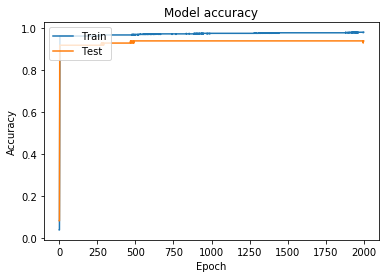

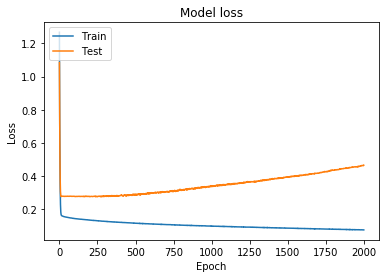

In [154]:

X = df.iloc[:,:-1]
Y = df.iloc[:,-1]
print(X)
print(Y)


def create_model_null():
    model = Sequential()
    model.add(Dense(24,input_dim = 12, activation = 'sigmoid'))
    model.add(Dense(1,activation = 'sigmoid'))
    return model


'''
Model just with backpropagation
'''
def BP(X,Y):
    n = create_model_null()
    n.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    history = n.fit(X, Y, validation_split=0.2, epochs=2000, batch_size=20, verbose=1, shuffle = True)
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
BP(X,Y)

In [155]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1) 
# 70% training and 30% test
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9383561643835616
